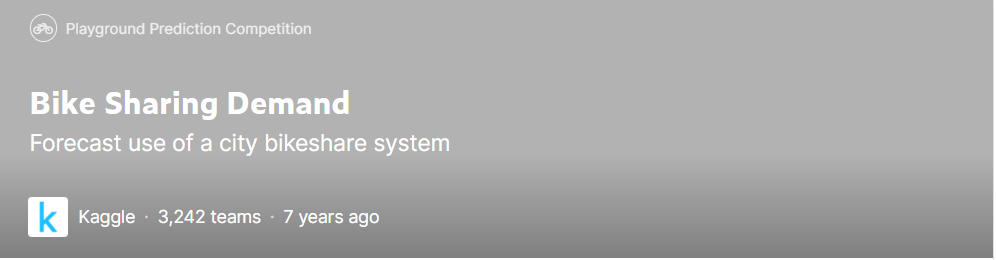
ref) https://www.kaggle.com/c/bike-sharing-demand

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
submission=pd.read_csv('./sampleSubmission.csv')
test=pd.read_csv('./test.csv')
df=pd.read_csv('./train.csv')
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 0:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 1:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 2:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 3:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 4:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [4]:
df.shape

(10886, 12)

### 날짜타입 변환
- read: 날짜 타입으로 읽어오기
- astype : object > datetime64[ns] 
- to_datetime()

In [5]:
df['datetime']=pd.to_datetime(df['datetime'],format='%Y-%m-%d %H:%M:%S')
#test['datetime']=test['datetime'].apply(pd.to_datetime)

#datetime 타입에서 년,월,일,시간 추출
df['year']=df['datetime'].dt.year
df['month']=df['datetime'].dt.month
df['day']=df['datetime'].dt.day
df['hour']=df['datetime'].dt.hour
df['weekday']=df['datetime'].dt.dayofweek #0:월, 6:일

# test['year']=test['datetime'].dt.year
# test['month']=test['datetime'].dt.month
# test['day']=test['datetime'].dt.day
# test['hour']=test['datetime'].dt.hour

In [6]:
df.drop('datetime',axis=1,inplace=True)
#drop안하고 set_index함수 쓰는 것 가능,밖으로 꺼낼 땐 reset_index

### EDA
https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile

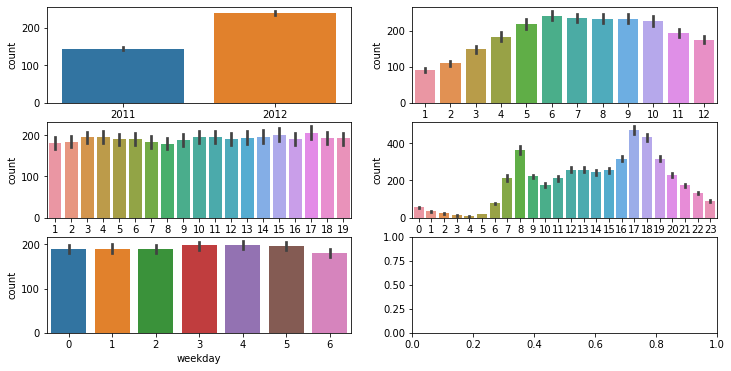

In [7]:
p,axes = plt.subplots(3,2,figsize=(12,6))
#sns.countplot(data=df,x='year')
sns.barplot(x='year',y='count',data=df,ax=axes[0][0])
sns.barplot(x='month',y='count',data=df,ax=axes[0][1])
sns.barplot(x='day',y='count',data=df,ax=axes[1][0])
sns.barplot(x='hour',y='count',data=df,ax=axes[1][1])
sns.barplot(x='weekday',y='count',data=df,ax=axes[2][0])
plt.show()

* 주말 ~ 평일 : 차이 무의미하다
* 날씨 : 5월 ~ 10월
* 시간 : 7 ~ 9시 , 17 ~ 18시  --> 출퇴근,통학용 주로 이용될 듯 하다.

<pre>  
평일/휴일
    'holiday', 'workingday' 

계절
    'season', 'weather', 'temp', 'atemp', 'humidity', 'windspeed'

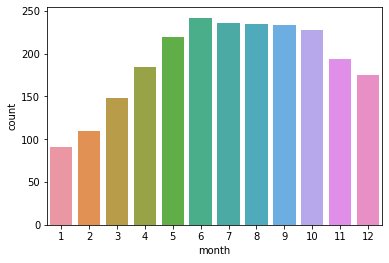

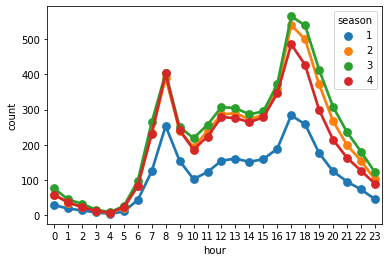

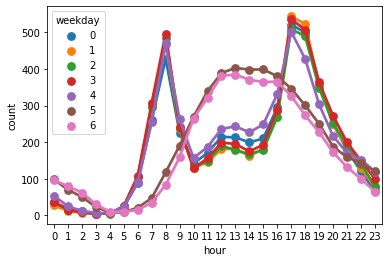

In [8]:
mm=pd.DataFrame(df.groupby("month")["count"].mean()).reset_index()
ms=mm.sort_values(by='count',ascending=False)
sns.barplot(data=ms,x="month",y="count")
plt.show()

hh=pd.DataFrame(df.groupby(["hour","season"],sort=True)['count'].mean()).reset_index()
sns.pointplot(data=hh,x='hour',y='count',hue="season",join=True)
plt.show()

ww=pd.DataFrame(df.groupby(["hour","weekday"],sort=True)['count'].mean()).reset_index()
sns.pointplot(data=ww,x='hour',y='count',hue="weekday",join=True)
plt.show()

##### 'weather','temp','atemp','humidity','windspeed'

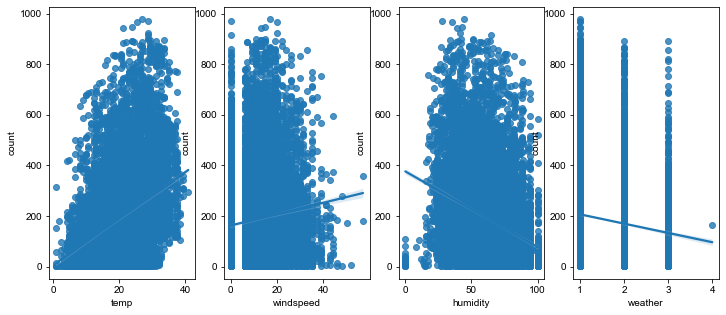

In [9]:
fig,axes = plt.subplots(1,4,figsize=(12,5))
sns.set()
sns.regplot(x="temp", y="count", data=df,ax=axes[0])
sns.regplot(x="windspeed", y="count", data=df,ax=axes[1])
sns.regplot(x="humidity", y="count", data=df,ax=axes[2])
sns.regplot(x="weather",y="count",data=df,ax=axes[3])
plt.show()

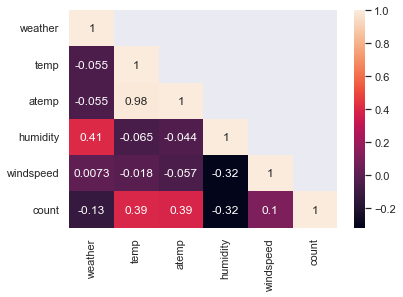

In [10]:
ww = df[['weather','temp','atemp','humidity','windspeed','count']].corr()
mask = np.array(ww)
mask[np.tril_indices_from(mask)] = False
sns.heatmap(ww,annot=True,mask=mask)
plt.show()

-  "atemp" and "temp" has got strong correlation with each other. so that one of them has to be dropped.</br>
- "weather" and "windspeed" have to be considered as they have got leak correlation one another. 

<pre>
* temp    - atemp     : 다중공선                 --> 피쳐 drop
* weather - count     : -0.13 별 관계가 없다      --> weather 4 아웃라이어 처리 안함
* weather - windspeed :  0.10 아무 관계도 아니다  --> 0 데이터 처리 

* weather - humidity  :  0.41 약한 상관관계

In [11]:
df.drop('atemp',axis=1,inplace=True)

##### casual,registered,count

In [12]:
#casual + registerd = count 
#혹시나 해서 casual + registerd != count 찾아봤지만 없었다
df[df['casual']+df['registered']!=df['count']]

,season,holiday,workingday,weather,temp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday


In [13]:
df.drop(['casual','registered'],axis=1,inplace=True)

##### 전체 heatmap

<AxesSubplot:>

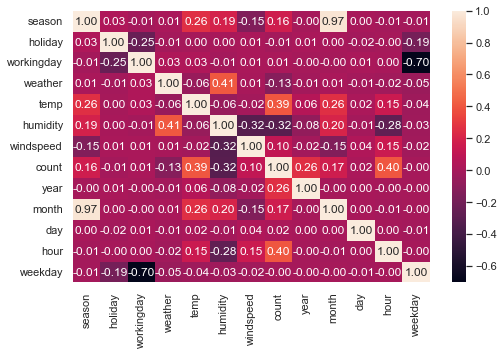

In [14]:
plt.figure(figsize=(8,5))
sns.heatmap(df.corr(),annot=True,fmt=".2f")

In [15]:
## seanson과 month 둘 중 하나 버려도 된다 (다중공선이기 때문) > 학습 후 결정

### feature engineering

-'windspeed' feature 결측치 채우기
: 예측모델을 이용한 결측처리
* weather - count     : -0.13 별 관계가 없다
* weather - windspeed :  0.10 아무 관계도 아니다


In [16]:
df['windspeed'].value_counts()  # 0: 1313건

0.0000     1313
8.9981     1120
11.0014    1057
12.9980    1042
7.0015     1034
15.0013     961
6.0032      872
16.9979     824
19.0012     676
19.9995     492
22.0028     372
23.9994     274
26.0027     235
27.9993     187
30.0026     111
31.0009      89
32.9975      80
35.0008      58
39.0007      27
36.9974      22
43.0006      12
40.9973      11
43.9989       8
46.0022       3
56.9969       2
47.9988       2
51.9987       1
50.0021       1
Name: windspeed, dtype: int64

In [17]:
df[df['windspeed']==0].shape,df[df['windspeed']==0].shape[0]/df.shape[0]

((1313, 13), 0.12061363218813155)

In [18]:
df[df['windspeed']!=0].shape

(9573, 13)

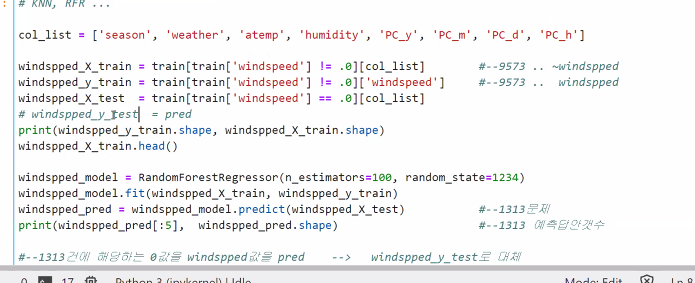
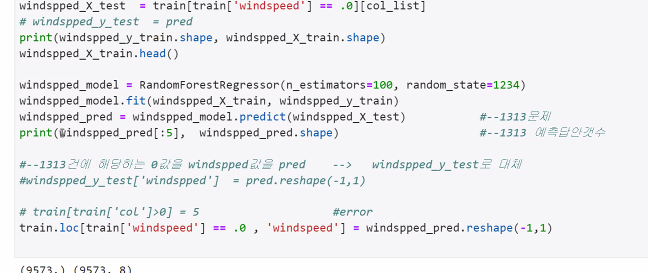

In [20]:
from sklearn.ensemble import RandomForestRegressor
col_list=['season','weather', 'temp', 'humidity','year', 'month', 'day', 'hour']

windspped_X_train = df[df['windspeed'] != .0][col_list]        #--9573 .. ~windspped
windspped_y_train = df[df['windspeed'] != .0]['windspeed']     #--9573 ..  windspped
windspped_X_test  = df[df['windspeed'] == .0][col_list] 
# windspped_y_test  = pred
print(windspped_y_train.shape, windspped_X_train.shape)
windspped_X_train.head()

windspped_model = RandomForestRegressor(n_estimators=100, random_state=1234)
windspped_model.fit(windspped_X_train, windspped_y_train)
windspped_pred = windspped_model.predict(windspped_X_test)           #--1313문제
print(windspped_pred[:5],  windspped_pred.shape)                     #--1313 예측답안갯수

#--1313건에 해당하는 0값을 windspped값을 pred    -->   windspped_y_test로 대체
#windspped_y_test['windspped']  = pred.reshape(-1,1)

# train[train['col']>0] = 5                    #error
df.loc[df['windspeed'] == .0 , 'windspeed'] = windspped_pred.reshape(-1,1)


(9573,) (9573, 8)
[11.791665 13.32161  13.161614  9.951644  9.191596] (1313,)


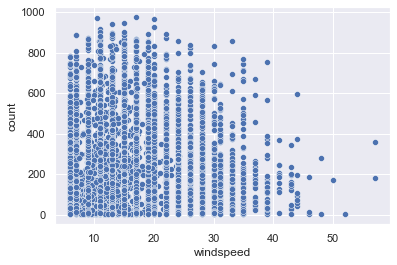

In [21]:
sns.scatterplot(x="windspeed", y="count", data=df)
plt.show()

In [38]:
df[['season', 'holiday', 'workingday', 'weather','year', 'month', 'day', 'hour', 'weekday']]=df[['season', 'holiday', 'workingday', 'weather','year', 'month', 'day', 'hour', 'weekday']].astype('category')

### 모델 - 1차 점수

In [39]:
from sklearn.model_selection import train_test_split

X=df[df.columns.difference(['count'])]
y=df['count']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0,shuffle=False)

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf=RandomForestRegressor(random_state=0,n_estimators=100)
rf.fit(X_train,y_train)
pred=rf.predict(X_test)
rmse = mean_squared_error(y_test,pred,squared=False)
print(rmse)

72.78689434337936


#### target 로그 변환

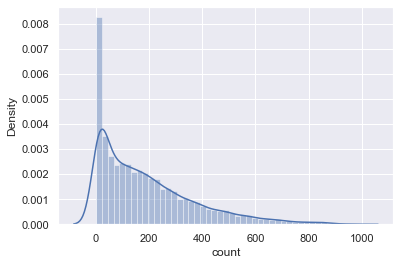

In [25]:
sns.distplot(y)
plt.show()

0~200 사이에 왜곡되어 있는 값을 정규분포로 바꾸는 가장 일반적인 방법은 로그 변환

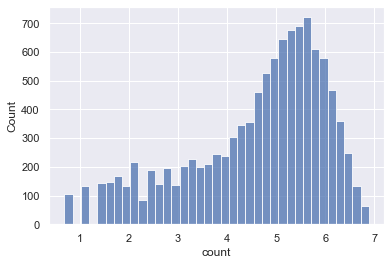

In [26]:
ylog=np.log1p(y)
sns.histplot(ylog)
plt.show()

#### 2차 점수

In [27]:
from sklearn.model_selection import train_test_split

X=df[df.columns.difference(['count'])]
ylog=np.log1p(y)

X_train,X_test,y_train,y_test = train_test_split(X,ylog,test_size=0.2,random_state=0,shuffle=False)

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf=RandomForestRegressor(random_state=0,n_estimators=100)
rf.fit(X_train,y_train)
pred=rf.predict(X_test)

y_test_exp=np.expm1(y_test)
pred_exp=np.expm1(pred)

mse = mean_squared_error(y_test_exp,pred_exp)
rmse = mean_squared_error(y_test_exp,pred_exp,squared=False)
print(f'mse:{mse}, rmse: {rmse}')

mse:8378.070529306018, rmse: 91.53180064494535


#### 숫자형 > 카테고리형 원핫인코딩